# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical [US stock prices in the last 5 years](https://intrinio.com/bulk-financial-data-downloads/all). Only the New German Fund (GF) will be considered for analysis. 

There roughly 1000 days of recoreded trading for GF.

## Clean data 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# data = pd.read_csv('/content/gdrive/My Drive/Dataset/Dow_Jones_Industrial_Average_Historical_Data.csv', index_col=['Date'], parse_dates=['Date'])
data = pd.read_csv('/content/gdrive/My Drive/Dataset/Dow_Jones_Industrial_Average_Historical_Data.csv')
data.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,1/1/1990,2590.54,2748.72,2834.04,2513.06,22.61M,-5.91%
1,1/2/1990,2627.25,2594.14,2674.32,2540.99,19.85M,1.42%
2,1/3/1990,2707.21,2621.62,2775.00,2607.88,20.16M,3.04%
3,1/4/1990,2656.76,2684.01,2793.47,2627.70,16.82M,-1.86%
4,1/5/1990,2876.66,2668.46,2908.21,2651.35,20.76M,8.28%
5,1/6/1990,2880.69,2900.97,2956.93,2821.53,21.29M,0.14%
6,1/7/1990,2905.20,2883.17,3024.26,2833.17,21.17M,0.85%
7,1/8/1990,2614.36,2909.90,2931.19,2459.41,26.24M,-10.01%
8,1/9/1990,2452.48,2590.84,2665.35,2367.82,20.45M,-6.19%
9,1/10/1990,2442.33,2474.25,2565.35,2344.31,21.78M,-0.41%


In [ ]:
data.shape

(360, 7)

In [ ]:
data.dtypes

Date         object
Price       float64
Open        float64
High        float64
Low         float64
Vol.         object
Change %     object
dtype: object

In [ ]:
# data = data[data.TICKER != 'GEF']
# data = data[data.TYPE != 'Intraday']

In [ ]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,1/1/1990,2590.54,2748.72,2834.04,2513.06,22.61M,-5.91%
1,1/2/1990,2627.25,2594.14,2674.32,2540.99,19.85M,1.42%
2,1/3/1990,2707.21,2621.62,2775.00,2607.88,20.16M,3.04%
3,1/4/1990,2656.76,2684.01,2793.47,2627.70,16.82M,-1.86%
4,1/5/1990,2876.66,2668.46,2908.21,2651.35,20.76M,8.28%


In [ ]:
drop_cols = [ 'Vol.', 'Change %']
data.drop(drop_cols, axis=1, inplace=True)

In [ ]:
data.head()

,Date,Price,Open,High,Low
0,1/1/1990,2590.54,2748.72,2834.04,2513.06
1,1/2/1990,2627.25,2594.14,2674.32,2540.99
2,1/3/1990,2707.21,2621.62,2775.00,2607.88
3,1/4/1990,2656.76,2684.01,2793.47,2627.70
4,1/5/1990,2876.66,2668.46,2908.21,2651.35


## Exploratory data analysis (EDA)

In [ ]:
x = data.Date
y = data.Price

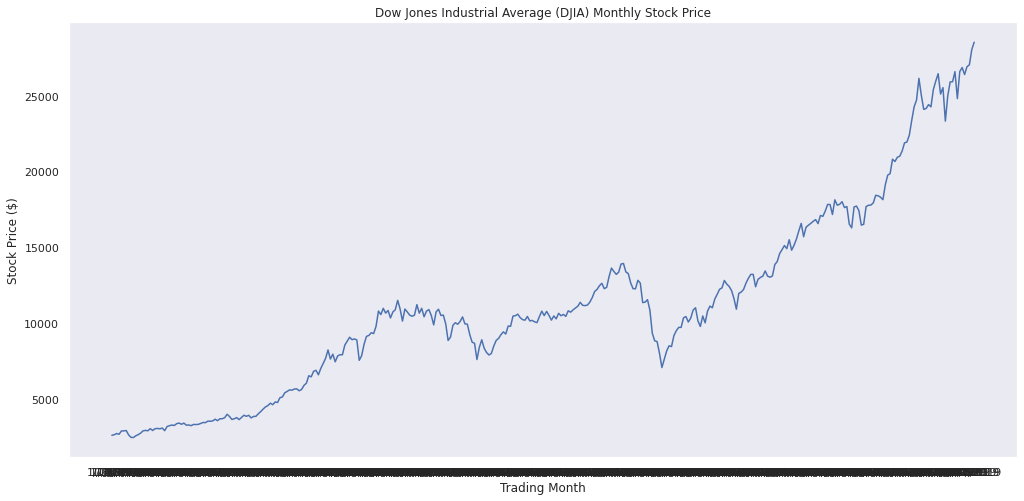

In [ ]:
plt.figure(figsize=(17, 8))
plt.plot(x,y)
plt.title('Dow Jones Industrial Average (DJIA) Monthly Stock Price')
plt.ylabel('Stock Price ($)')
plt.xlabel('Trading Month')
plt.grid(False)
plt.show()

### Moving average

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

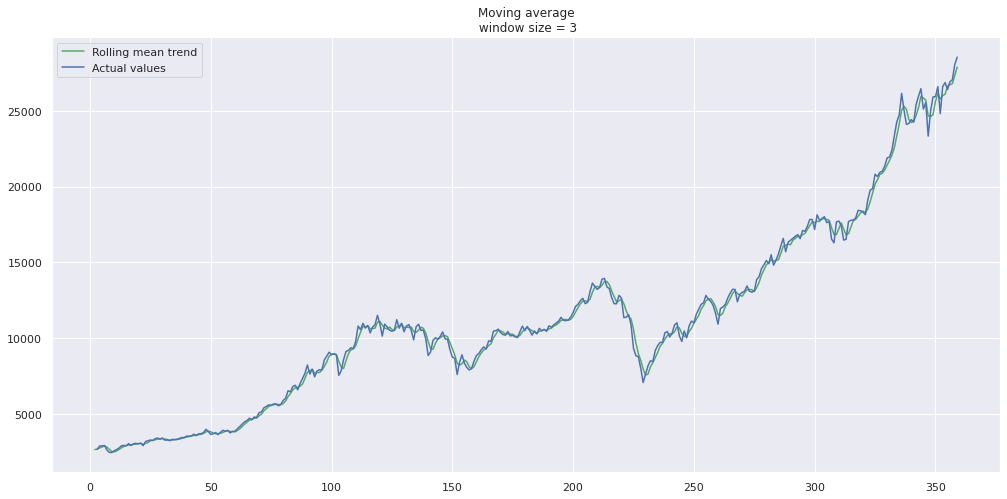

In [ ]:
#Smooth by the previous 5 days (by week)
plot_moving_average(data.Price, 3)

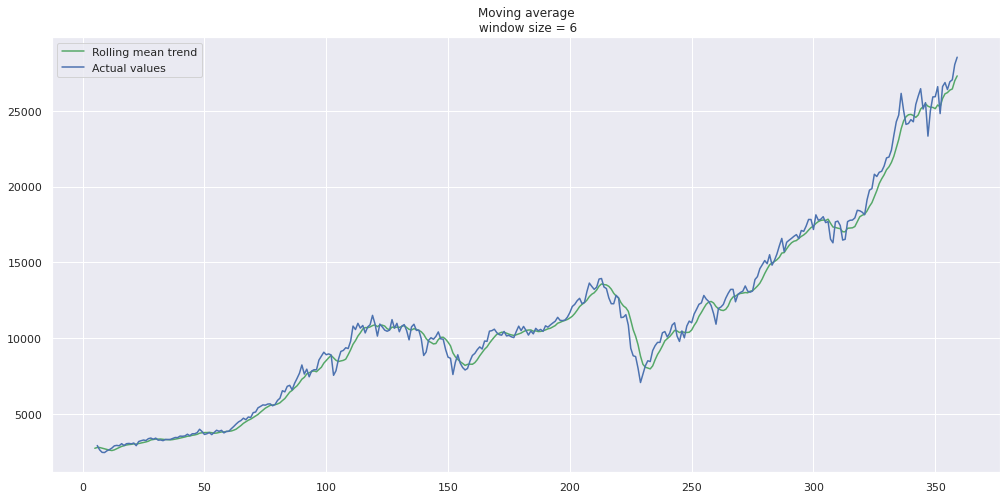

In [ ]:
#Smooth by the previous month (30 days)
plot_moving_average(data.Price, 6)

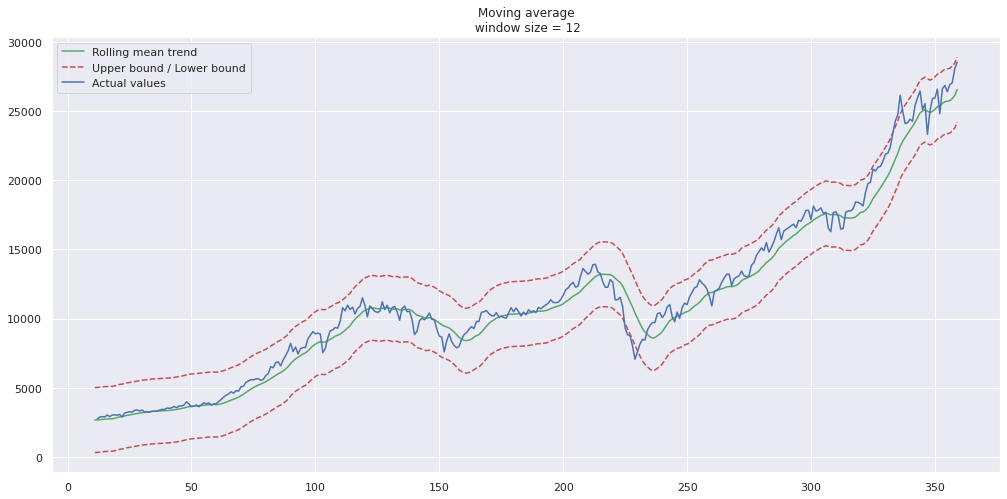

In [ ]:
#Smooth by previous quarter (90 days)
plot_moving_average(data.Price, 12, plot_intervals=True)

### Exponential smoothing

In [ ]:
def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);

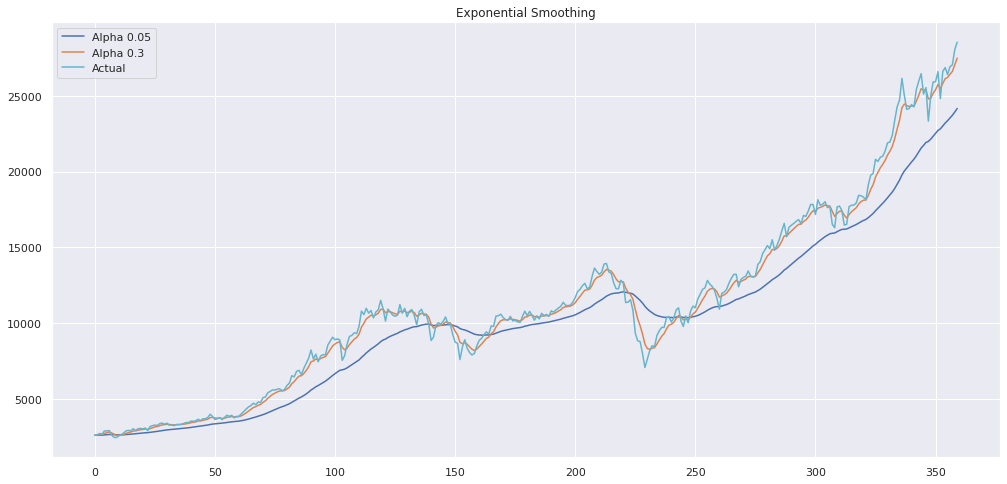

In [ ]:
plot_exponential_smoothing(data.Price, [0.05, 0.3])

### Double exponential smoothing 

In [ ]:
def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

In [ ]:
def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

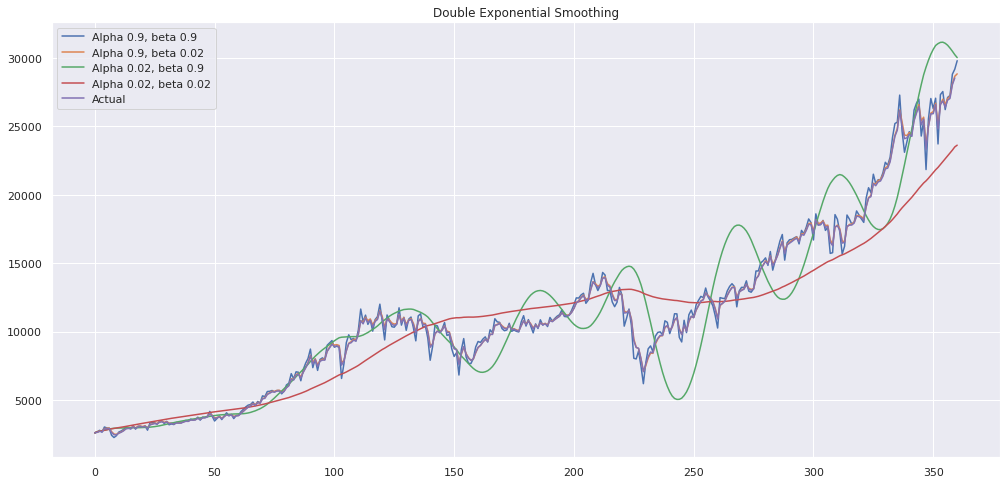

In [ ]:
plot_double_exponential_smoothing(data.Price, alphas=[0.9, 0.02], betas=[0.9, 0.02])

## Stationarity 

In [ ]:
X = data["Price"].values
result = sm.tsa.stattools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 1.585773
p-value: 0.997814
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Failed to Reject Ho - Time Series is Non-Stationary


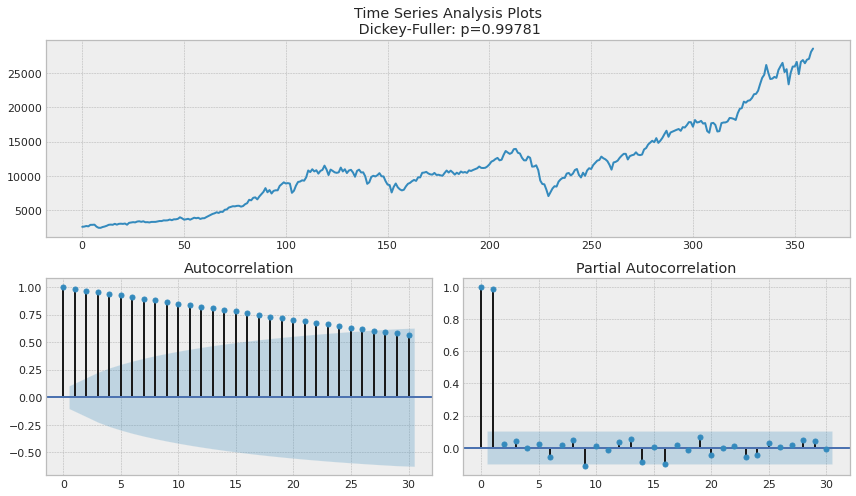

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.Price, lags=30)

### ACF shows significant correlation because there is an obvious downtrend direction of graph. Prvious y value will affect future y value

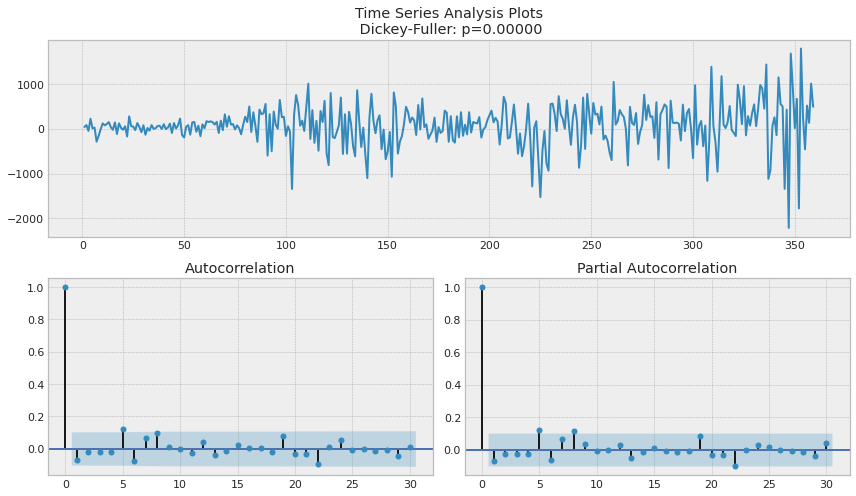

In [ ]:
data_diff = data.Price - data.Price.shift(1)

tsplot(data_diff[1:], lags=30)

In [ ]:
X = data["Price"].values
result = sm.tsa.stattools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: 1.585773
p-value: 0.997814
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Failed to Reject Ho - Time Series is Non-Stationary


## SARIMA

In [ ]:
#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data.Price, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [ ]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(data.Price, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Price   No. Observations:                  360
Model:             SARIMAX(0, 1, 0)x(0, 1, 2, 5)   Log Likelihood               -2690.308
Date:                           Sun, 18 Apr 2021   AIC                           5386.616
Time:                                   15:15:54   BIC                           5398.224
Sample:                                        0   HQIC                          5391.234
                                           - 360                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5       -0.8437      0.032    -26.153      0.000      -0.907      -0.781
ma.S.L10      -0.0882      0.040     -2.196

In [ ]:
def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'Price': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=data.Price.shape[0], end=data.Price.shape[0] + 5))
print(mean_absolute_percentage_error(data.Price[s+d:], best_model.fittedvalues[s+d:]))

360    28479.399191
361    28736.090061
362    28635.237948
363    29015.558481
364    29328.858480
365    29313.081567
dtype: float64
3.2450230231231565


### AR

In [ ]:
remove_cols = [ 'Date', 'Open', 'High', 'Low']
data.drop( remove_cols, axis=1, inplace=True)

In [ ]:
# Function to insert row in the dataframe
def Insert_row(row_number, data, row_value):
    # Starting value of upper half
    start_upper = 0
   
    # End value of upper half
    end_upper = row_number
   
    # Start value of lower half
    start_lower = row_number
   
    # End value of lower half
    end_lower = data.shape[0]
   
    # Create a list of upper_half index
    upper_half = [*range(start_upper, end_upper, 1)]
   
    # Create a list of lower_half index
    lower_half = [*range(start_lower, end_lower, 1)]
   
    # Increment the value of lower half by 1
    lower_half = [x.__add__(1) for x in lower_half]
   
    # Combine the two lists
    index_ = upper_half + lower_half
   
    # Update the index of the dataframe
    data.index = index_
   
    # Insert a row at the end
    data.loc[row_number] = row_value
    
    # Sort the index labels
    data = data.sort_index()
   
    # return the dataframe
    return data

In [ ]:
# Let's create a row which we want to insert
row_number = 0
row_value = [0.00]
  
if row_number > data.index.max()+1:
    print("Invalid row_number")
else:
      
    # Let's call the function and insert the row
    # at the second position
    data = Insert_row(row_number, data, row_value)
   
    # Print the updated dataframe
    print(data)

        Price
0        0.00
1     2590.54
2     2627.25
3     2707.21
4     2656.76
..        ...
356  26403.28
357  26916.83
358  27046.23
359  28051.41
360  28538.44

[361 rows x 1 columns]


In [ ]:
data.head()

,Price
0,0.00
1,2590.54
2,2627.25
3,2707.21
4,2656.76


In [ ]:
data["Price_shifted"] = data ["Price"].shift(1)

In [ ]:
data.head()

,Price,Price_shifted
0,0.00,NaN
1,2590.54,0.00
2,2627.25,2590.54
3,2707.21,2627.25
4,2656.76,2707.21


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.head()

,Price,Price_shifted
1,2590.54,0.00
2,2627.25,2590.54
3,2707.21,2627.25
4,2656.76,2707.21
5,2876.66,2656.76


In [ ]:
y = data.Price.values
X = data.Price_shifted.values

In [ ]:
train_size = int(len(X) * 0.70)

In [ ]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [ ]:
X_train = X_train.reshape(-1,1) # covert data from 1D to 2D
X_test = X_test.reshape(-1,1)

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
lr.coef_ #alpha value

array([0.98258325])

In [ ]:
lr.intercept_ #beta 1 value

182.46164687278178

In [ ]:
y_pred = lr.predict(X_test)

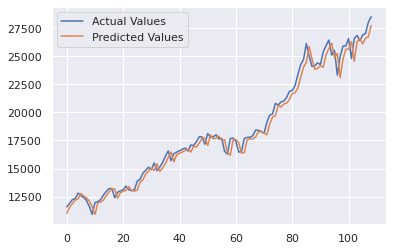

In [ ]:
# plt.plot(y_test[-10:], label="Actual Values") # only last 10 values are selected
# plt.plot(y_pred[-10:], label="Predicted Values") # only last 10 values are selected
plt.plot(y_test, label="Actual Values") # all 10 values are selected
plt.plot(y_pred, label="Predicted Values") # all values are selected
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(1,0))

In [ ]:
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  251
Model:                     ARMA(1, 0)   Log Likelihood               -1847.951
Method:                       css-mle   S.D. of innovations            377.754
Date:                Sun, 18 Apr 2021   AIC                           3701.902
Time:                        15:15:55   BIC                           3712.478
Sample:                             0   HQIC                          3706.158
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7262.5142   2972.696      2.443      0.015    1436.136    1.31e+04
ar.L1.y        0.9950      0.005    196.844      0.000       0.985       1.005
                                    Roots           

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(y_train, order=(1,1,0))

In [ ]:
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  250
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1837.309
Method:                       css-mle   S.D. of innovations            376.264
Date:                Sun, 18 Apr 2021   AIC                           3680.617
Time:                        15:15:55   BIC                           3691.182
Sample:                             1   HQIC                          3684.869
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.6619     24.885      1.353      0.177     -15.112      82.436
ar.L1.D.y      0.0439      0.063      0.696      0.487      -0.080       0.168
                                    Roots           